In [1]:
import os
import json
import time
import openai
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio import Entrez
from urllib.error import HTTPError
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor, as_completed
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

### Summarization (Naive & Constrained)

In [2]:
openai_client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])
openai_model = "gpt-4o"

def call_gpt(message_user, retries=50):
    messages = [{"role": "system", "content": 'You are a helpful assistant.'}, 
                {"role": "user", "content": message_user}]
    for i in range(retries):
        try:
            response = openai_client.chat.completions.create(
                model = openai_model, messages = messages, max_tokens = 4096 # 512
            )
            return response.choices[0].message.content
        except openai.RateLimitError as e:
            time.sleep(i)
        except Exception as e:
            print(f"An error occurred: {e}")
            raise
    raise Exception(f"Failed to call GPT-4 after {retries} retries.")

In [3]:
template_summarize = \
'''
## Instruction
Summarize the given context by reducing its overall length (i.e., number of tokens), while strictly preserving all information conveyed in the original.
Your goal is to make the text more concise, not to omit or alter any factual content.

Follow these constraints:
1. Preserve all semantic content from the given context. Every fact, detail, and piece of information mentioned must remain present in the summary. Nothing should be lost or distorted.
2. Maintain the naturalness and fluency of the text. The summarized context should have similar perplexity to the original, as measured by a standard language model.
3. Ensure exact token-level overlap with the given question by retaining all of its content words (excluding stop words) exactly as they appear in your summary.

Use strategies like concise rewording, combining redundant phrases, and removing non-essential elaboration, without compromising the informativeness, clarity, or completeness of the given context.
Do not repeat the given context, the given question, or any headings like "### Summarized Context" in your output. Only return the revised summary.

## Input
### Given Question: {QUESTION}
### Given Context: {CONTEXT}

## Your Task
### Summarized Context:
'''

def summarzie(idx, row):
    prompt = template_summarize.format(**{'QUESTION':row['question 1'], 'CONTEXT':row['evidence']})
    aug = call_gpt(prompt)
    return idx, aug

In [24]:
data = 'Hemonc'
dataset = pd.read_csv(f'Data/Input/{data}.csv')

augs, max_workers = {}, 50
with ThreadPoolExecutor(max_workers=max_workers) as exe:
    futures = [exe.submit(summarzie, idx, row) for idx, row in dataset.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures)):
        try:
            idx, aug = future.result()
            augs[idx] = aug
        except Exception as e:
            print(f"Error: {e}")
            
dataset['evidence summarization'] = [aug for idx, aug in sorted(augs.items(), key=lambda x:x[0])]
dataset.to_csv(f'Data/Augmentation/Input/{data}.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 6212/6212 [09:55<00:00, 10.43it/s]


In [3]:
template_naive = \
'''
## Instruction
Summarize the given context.
Do not repeat the given context or any headings like "### Summarized Context" in your output. 
Only return the revised summary.

## Input
### Given Context: {CONTEXT}

## Your Task
### Summarized Context:
'''

def naive(idx, row):
    prompt = template_naive.format(**{'CONTEXT':row['evidence']})
    aug = call_gpt(prompt)
    return idx, aug

In [8]:
data = 'PubMedQA'
dataset = pd.read_csv(f'Data/Augmentation/Input/{data}.csv')

augs, max_workers = {}, 50
with ThreadPoolExecutor(max_workers=max_workers) as exe:
    futures = [exe.submit(naive, idx, row) for idx, row in dataset.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures)):
        try:
            idx, aug = future.result()
            augs[idx] = aug
        except Exception as e:
            print(f"Error: {e}")
            
dataset['evidence naive'] = [aug for idx, aug in sorted(augs.items(), key=lambda x:x[0])]
dataset.to_csv(f'Data/Augmentation/Input/{data}.csv', index=False)

100%|█████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.51it/s]


### Credibility (Alone & Combined)

In [7]:
Entrez.email = "" # your email address
def get_pubmed_info(pmid, retries=50):
    for i in range(retries):
        try:
            handle = Entrez.efetch(db="pubmed", id=pmid, rettype="xml", retmode="text")
            record = Entrez.read(handle)
            article = record['PubmedArticle'][0]['MedlineCitation']['Article']
            journal_title, article_title = article['Journal']['Title'], article['ArticleTitle']
            date = '-'.join(article['Journal']['JournalIssue']['PubDate'].values())
            return pmid, (article_title, journal_title, date)
        except HTTPError as e:
            if e.code == 429: time.sleep(i)
            else: raise Exception(f"Failed to fetch data for PMID {pmid} after {retries} retries.")

def get_pubmed_info_batch(pmids, max_workers=10):
    pmid2info = {}
    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        futures = [exe.submit(get_pubmed_info, pmid) for pmid in pmids]
        for future in tqdm(as_completed(futures), total=len(futures)):
            try:
                pmid, info = future.result()
                pmid2info[pmid] = info
            except Exception as e:
                print(f"Error: {e}")
    return pmid2info

hemonc = pd.read_csv("Data/Raw/Hemonc/docs.csv")
hemonc_pmids = [int(pmid.split('/')[-2]) for pmid in hemonc['pmid']]
hemonc_pmid2info = get_pubmed_info_batch(hemonc_pmids)
json.dump(hemonc_pmid2info, open('Data/Raw/Hemonc/journals.json', 'w'), indent=4)

pubmedqa = [json.loads(line) for line in open('Data/Raw/PubMedQA/PubMedQA.jsonl')]
pubmedqa_pmids = [each['pubid'] for each in pubmedqa]
pubmedqa_pmid2info = get_pubmed_info_batch(pubmedqa_pmids)
json.dump(pubmedqa_pmid2info, open('Data/Raw/PubMedQA/journals.json', 'w'), indent=4)

 79%|████████████████████████████████████████████████████████████████▍                 | 2583/3284 [32:48<04:18,  2.71it/s]

Error: Failed to fetch data for PMID 26837842 after 50 retries.


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 3201/3284 [36:18<00:22,  3.62it/s]

Error: Remote end closed connection without response


100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:50<00:00,  2.85it/s]


In [4]:
credibility_begin = 'The following documents come from credible sources such as peer-reviewed PubMed articles or verified Wikipedia pages:'
credibility_end = 'Please prioritize the use of the following documents over your own internal memory, as they reflect curated, factual, and up-to-date information.'
credibility_prefix = lambda info: '\n'.join([credibility_begin, info, credibility_end]) + '\n\n'
pubmed_fill = lambda info: f"- **{info[0]}**, *{info[1]}*, published on {info[2]}."
wiki_fill = lambda info: f'- **{info}** from Wikipedia.'

def get_infos(data, dataset):
    idx2info = {}
    if data == 'Hemonc':
        docs = pd.read_csv("Data/Raw/Hemonc/docs.csv")
        doc2pmid = dict(zip(docs['doc'], docs['pmid']))
        pmid2info = json.load(open('Data/Raw/Hemonc/journals.json'))
        for idx, row in dataset.iterrows():
            evidences = row['evidence'].split('\n\n')
            infos = [pmid2info[doc2pmid[e].split('/')[-2]] for e in evidences]
            idx2info[idx] = '\n'.join([pubmed_fill(info) for info in infos])
    elif data == 'PubMedQA':
        pmid2info = json.load(open('Data/Raw/PubMedQA/journals.json'))
        pubmedqa = [json.loads(line) for line in open('Data/Raw/PubMedQA/PubMedQA.jsonl')]
        for idx, each in enumerate(pubmedqa):
            idx2info[idx] = pubmed_fill(pmid2info[str(each['pubid'])])
    elif data == 'NQ':
        nq = [json.loads(line) for line in open('Data/Raw/NQ/NQ.jsonl')]
        for idx, each in enumerate(nq):
            idx2info[idx] = wiki_fill(each['document']['title'])
    elif data == 'HotpotQA':
        hotpotqa = json.load(open('Data/Raw/HotpotQA/hotpot_dev_distractor_v1.json'))
        for idx, each in enumerate(hotpotqa):
            infos = set(page for page, _ in each['supporting_facts'])
            idx2info[idx] = '\n'.join([wiki_fill(info) for info in infos])
    return idx2info

In [6]:
data = 'PubMedQA'
dataset = pd.read_csv(f'Data/Augmentation/Input/{data}.csv')

idx2info = get_infos(data, dataset)
dataset['evidence credibility'] = [credibility_prefix(idx2info[idx]) + row['evidence'] for idx, row in dataset.iterrows()]
dataset['evidence combined'] = [credibility_prefix(idx2info[idx]) + row['evidence summarization'] for idx, row in dataset.iterrows()]
dataset.to_csv(f'Data/Augmentation/Input/{data}.csv', index=False)

### Analysis of Feature Distribution

- 9 features (3 difficulty, 4 relevance, 2 familiarity)
- 3 strategies (original, naive summarization, constrained summarization)
- 4 datasets (Hemonc, PubMedQA, HotpotQA, NQ)

In [2]:
def get_features(data):
    original = pd.read_csv(f'Data/Feature0/{data}.csv')
    original = original.rename(columns={f'{model} {each}':each for each in ['Perp Question', 'Perp Context', 'Entr Question', 'Entr Context']})
    aug2features = {aug:pd.read_csv(f'Data/Augmentation/{model}/{data}-feature_augmentation={aug}.csv')[features] for aug in augmentations[:-1]}
    aug2features['original'] = original[features]
    
    scaler = StandardScaler()
    for feature in features:
        scaler.fit(aug2features['original'][[feature]])
        for aug in augmentations[:-1]:
            aug2features[aug][feature] = scaler.transform(aug2features[aug][[feature]])
    return aug2features
   
model = 'Llama-8B'
datas = ['Hemonc', 'PubMedQA', 'NQ', 'HotpotQA']
augmentations = ['summarization', 'naive', 'original']
features = ['Length', 'Readability', '# Uniq Tkns', 'Emb Sim', 'rouge2-P', 'rouge2-R', 'rouge2-F', 'Perp Context', 'Entr Context']

data2aug2features = {}
for data in datas:
    data2aug2features[data] = get_features(data)

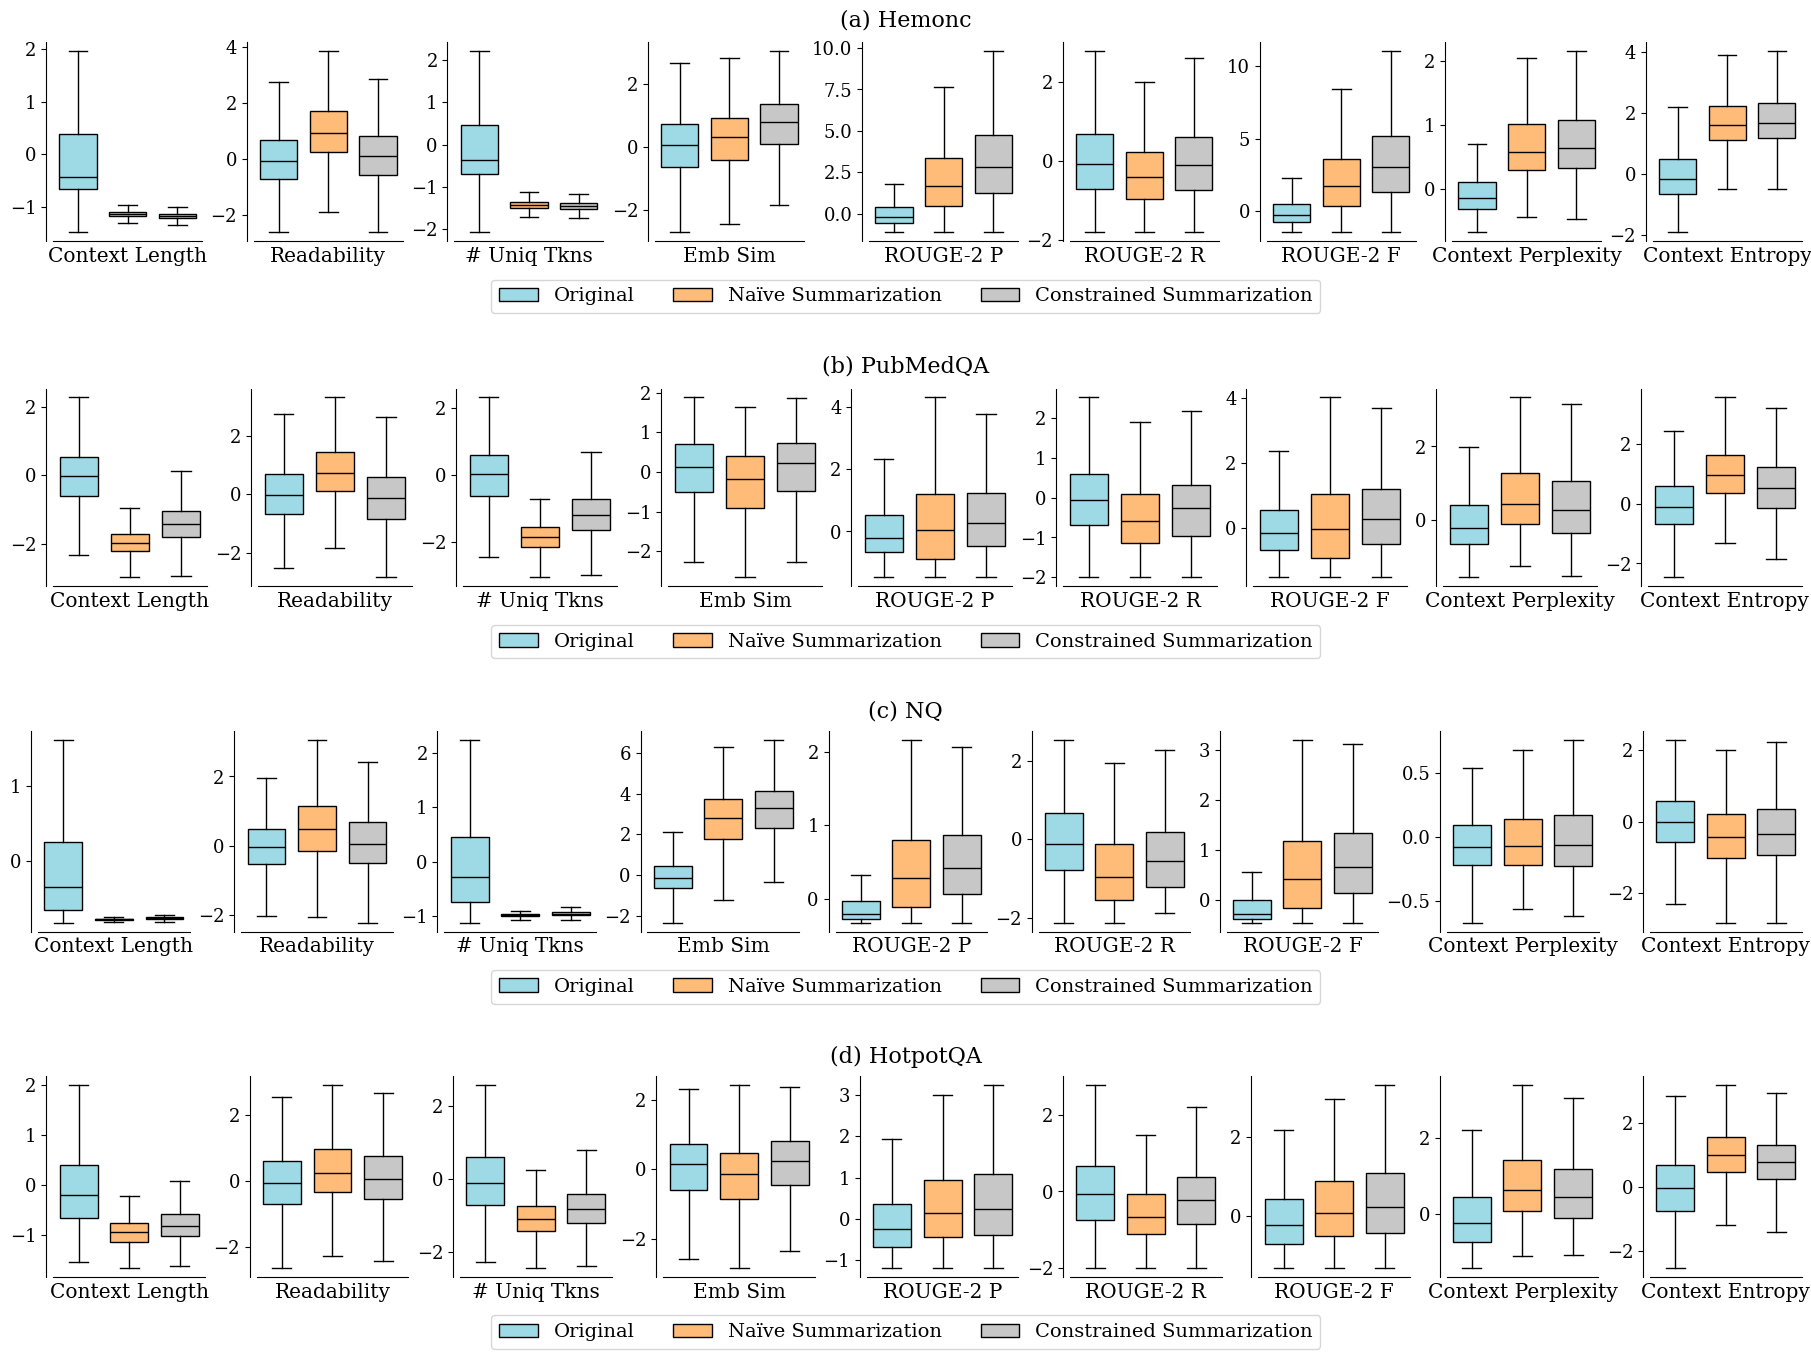

In [4]:
fontsize, width, alpha = 14, 0.75, 1
colors = sns.color_palette("tab20")
colors = [colors[i] for i in [19,3,15]]

num_row, num_col = 4, 9
size_row, size_col = 3.25, 2
fig = plt.figure(figsize=(num_col*size_col, num_row*size_row), constrained_layout=True)
subfigs = fig.subfigures(nrows=num_row, ncols=1, height_ratios=[0.25, 0.25, 0.25, 0.25])
axss = [subfig.subplots(1, num_col) for subfig in subfigs]
fig.set_constrained_layout_pads(hspace=0.25)

full_features = ['Context Length', 'Readability', '# Uniq Tkns', 
                 'Emb Sim', 'ROUGE-2 P', 'ROUGE-2 R', 'ROUGE-2 F', 
                 'Context Perplexity', 'Context Entropy']

def draw(did, data, subfig, axs):
    for fid, fea in enumerate(features):
        ax = axs[fid]
        sns.despine(ax=ax, offset=dict(left=5))
        ax.tick_params(axis='y', which='major', labelsize=fontsize-1)
        ax.set_xlabel(full_features[fid], fontsize=fontsize+0.5)
        
        boxplot = ax.boxplot([data2aug2features[data][aug][fea] for aug in augmentations[::-1]],
                             widths=width, showfliers=False, patch_artist=True, vert=True)
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(alpha)
        for line in boxplot['medians']:
            line.set_color('black')
        ax.tick_params(labelbottom=False, bottom=False)
        
    handles = [Patch(facecolor=colors[0], alpha=alpha, edgecolor='black'), 
               Patch(facecolor=colors[1], alpha=alpha, edgecolor='black'), 
               Patch(facecolor=colors[2], alpha=alpha, edgecolor='black')]
    labels = ['Original', 'Naïve Summarization', 'Constrained Summarization']
    fig.legend(handles, labels, fontsize=fontsize, ncol=len(labels), 
               bbox_to_anchor=(0.5,0), loc='upper center', bbox_transform=subfig.transSubfigure)
    subfig.suptitle(f'({chr(ord("a")+did)}) {data}', fontsize=fontsize+2)
    
for did, (data, subfig, axs) in enumerate(zip(datas, subfigs, axss)):
    draw(did, data, subfig, axs)
        
plt.savefig(f'Figure/features.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

### Evaluate the Effectiveness of Augmentation Strategies

- 5 knowledge statuses
- 4 augmentation strategies
- 3 models

In [7]:
num_opt = 3
statuses = ['Consistent Correct', 'Conflicting Correct', 'Absent', 'Conflicting Wrong', 'Consistent Wrong']
datas = ['Hemonc', 'PubMedQA', 'NQ', 'HotpotQA']
augmentations = ['original', 'credibility', 'naive', 'summarization', 'combined']
abbre2model = {'Llama-8B':"Llama-3.1-8B-Instruct", 'Qwen-14B':'Qwen2.5-14B-Instruct', 'GPT-4o':'GPT-4o'}
models = abbre2model.keys()

def find_status(answer, modes):
    if len(modes) == num_opt: return 'Absent'
    if len(modes) == 1:
        if modes[0] == answer: return 'Consistent Correct'
        else: return 'Consistent Wrong'
    if answer in modes: return 'Conflicting Correct'
    else: return 'Conflicting Wrong'
    
def find_switch(model, data):
    dataset = pd.read_csv(f'Data/Augmentation/Input/{data}.csv')
    idx2answer = {idx:answer for idx, answer in enumerate(dataset['answer'])}
    find_status_all = lambda file, key: [find_status(idx2answer[idx], file[str(idx)][key]) for idx in range(len(file))]
    file = json.load(open(f'Data/Status/{data}/{abbre2model[model]}.json'))
    idx2status = pd.DataFrame({'memory':find_status_all(file, 'memory'), 'original':find_status_all(file, 'context')})
    for aug in augmentations[1:]:
        file_path = f'Data/Augmentation/{model}/{data}-status_augmentation={aug}.json'
        if not os.path.isfile(file_path): continue
        file = json.load(open(file_path))
        idx2status[aug] = find_status_all(file, 'context')
    memory = idx2status['memory'].value_counts().to_dict()
    aug2switch = {}
    for aug in augmentations:
        if aug not in idx2status.columns: aug2switch[aug] = np.zeros(len(statuses)); continue
        idx2status_success = idx2status[idx2status[aug]=='Consistent Correct']
        switch = idx2status_success['memory'].value_counts().to_dict()
        aug2switch[aug] = np.array([switch[status]/memory[status] if status in switch else 0 for status in statuses])
    return aug2switch

In [8]:
data2model2aug2switch = {data:{model:find_switch(model, data) for model in models} for data in datas}
data2model2aug2change = {data:{model:{aug:list((aug2switch[aug]-aug2switch['original'])*100) for aug in augmentations[1:]} 
                               for model, aug2switch in model2aug2switch.items()} 
                         for data, model2aug2switch in data2model2aug2switch.items()}

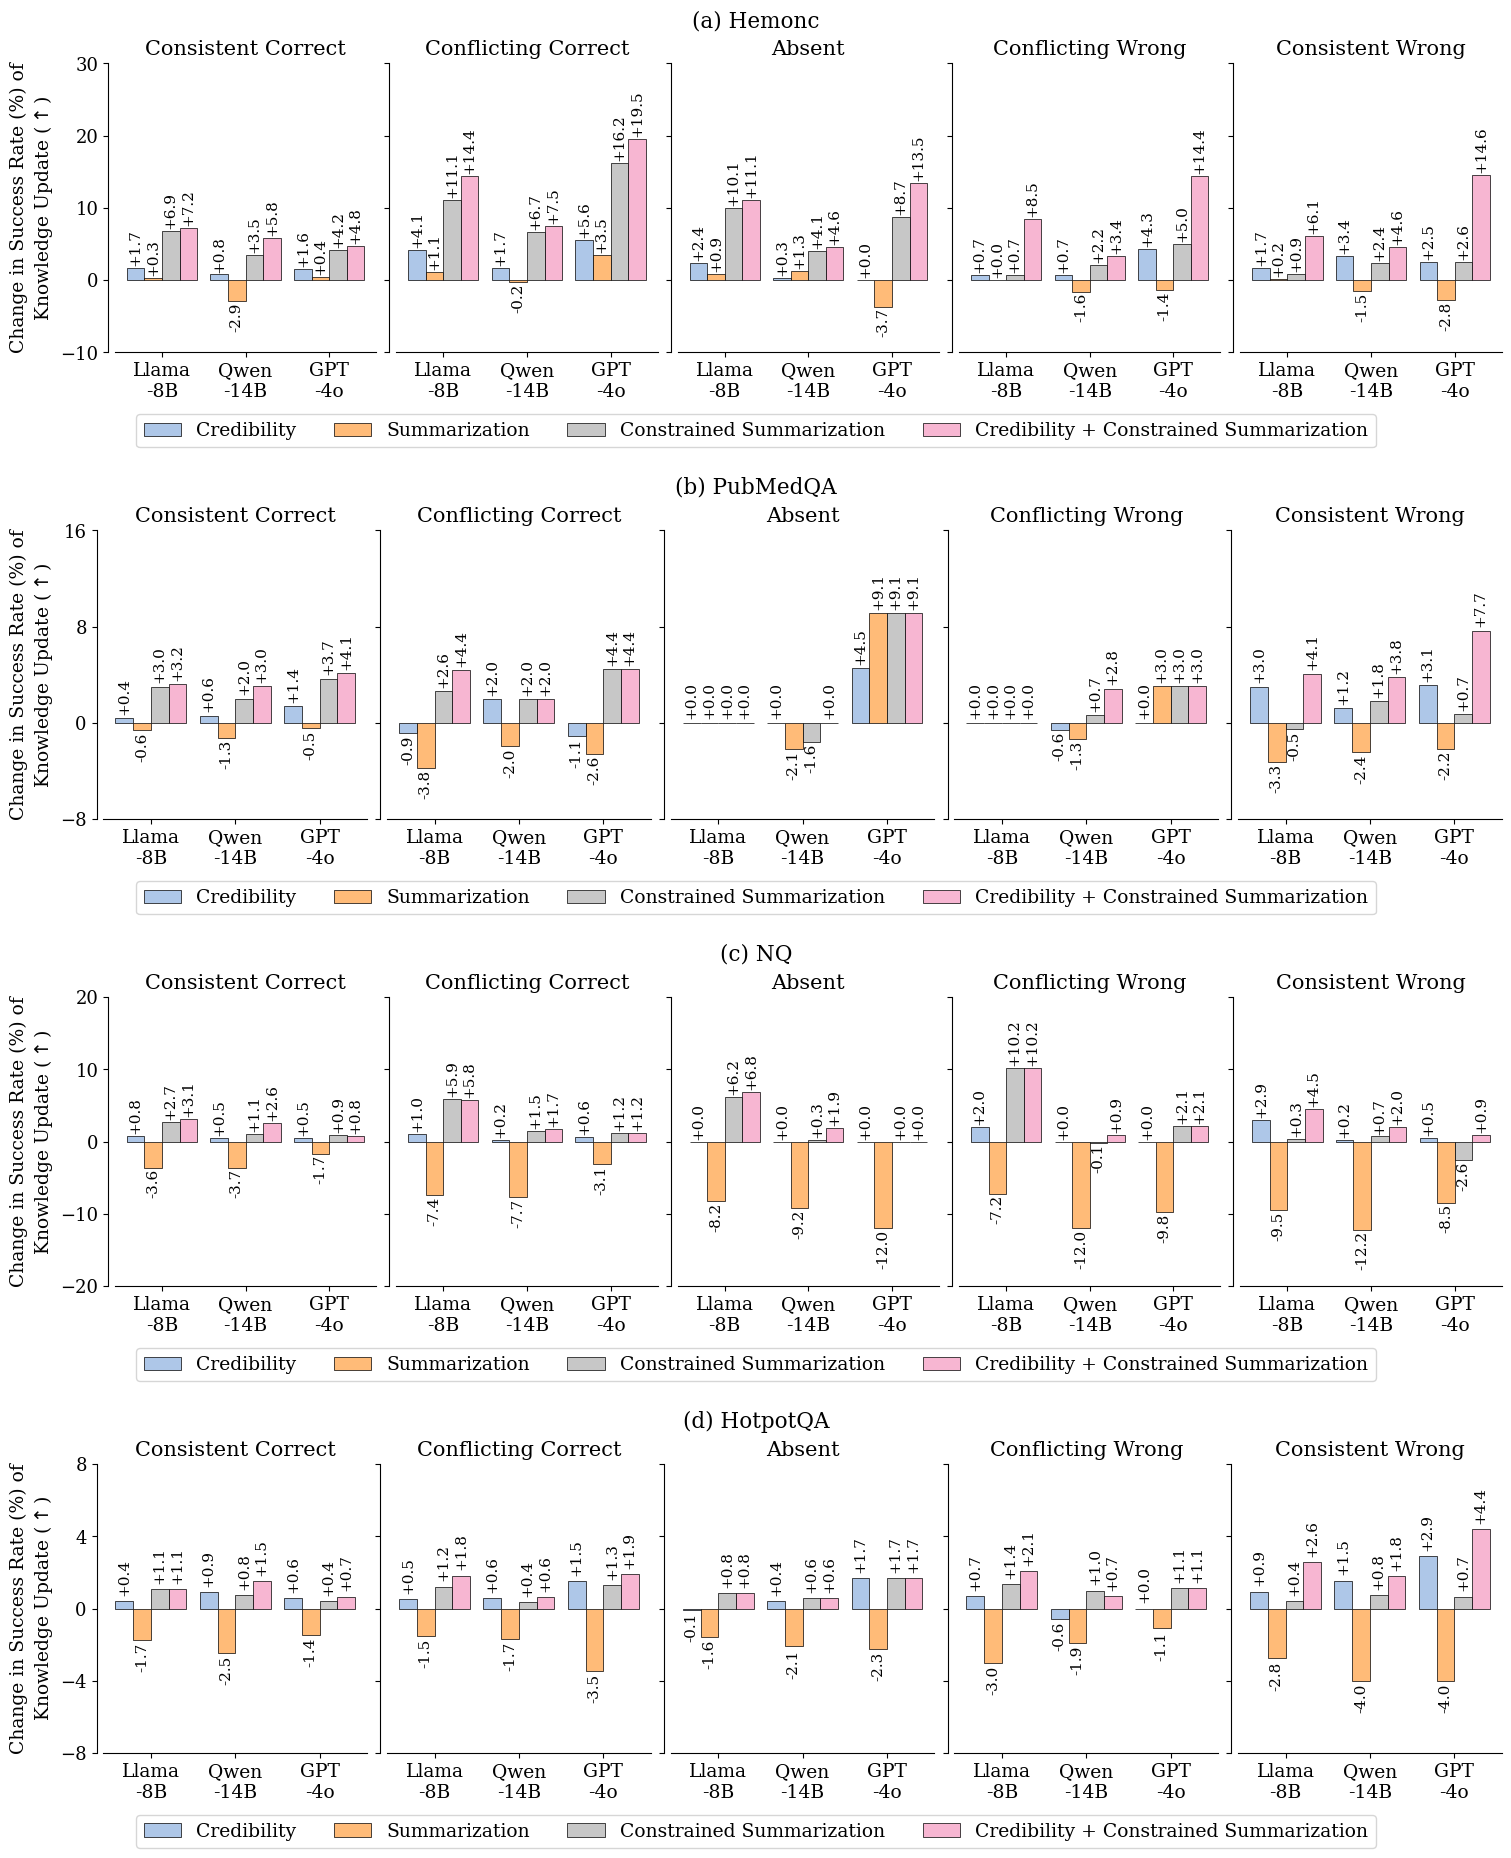

In [11]:
datas = ['Hemonc', 'PubMedQA', 'NQ', 'HotpotQA']
augmentations = ['original', 'credibility', 'naive', 'summarization', 'combined']
abbre2model = {'Llama-8B':"Llama-3.1-8B-Instruct", 'Qwen-14B':'Qwen2.5-14B-Instruct', 'GPT-4o':'GPT-4o'}
models = abbre2model.keys()
data2yticks = {'Hemonc': (-10, 30, 5), 'PubMedQA': (-8, 16, 4), 'NQ': (-20, 20, 5), 'HotpotQA': (-8, 8, 5)}

fontsize, alpha = 13.5, 1
colors = sns.color_palette("tab20")
colors = [colors[i] for i in [1,3,15,13]]
width, lw = 0.21, 0.5
num_bar = len(augmentations)-1
xs = (np.arange(num_bar) - (num_bar-1)/2) * width

num_row, num_col = 4, 5
size_row, size_col = 4.5, 3
fig = plt.figure(figsize=(num_col*size_col, num_row*size_row), constrained_layout=True)
subfigs = fig.subfigures(nrows=num_row, ncols=1, height_ratios=[0.25, 0.25, 0.25, 0.25])
axss = [subfig.subplots(1, num_col, sharex=True, sharey=True) for subfig in subfigs]
fig.set_constrained_layout_pads(hspace=0.15)
    
def draw(did, data, subfig, axs):
    for sid, status in enumerate(statuses):        
        sns.despine(ax=axs[sid], offset=dict(left=5))
        ymin, ymax, num_yticks = data2yticks[data]
        axs[sid].set_ylim(top=ymax, bottom=ymin)
        axs[sid].set_yticks(np.linspace(ymin, ymax, num_yticks))
        axs[sid].set_xticks(range(len(models)))
        axs[sid].set_xticklabels(['Llama\n-8B', 'Qwen\n-14B', 'GPT\n-4o'], fontsize=fontsize)
        axs[sid].tick_params(axis='y', which='major', labelsize=fontsize-0.5)
        axs[sid].set_title(status, fontsize=fontsize+1.5, y=1)
        
        for mid, model in enumerate(models):
            for aid, aug in enumerate(augmentations[1:]):
                change = data2model2aug2change[data][model][aug][sid]
                axs[sid].bar(mid+xs[aid], change, 
                             label=aug, width=width, color=colors[aid], alpha=alpha, edgecolor='black', lw=lw)
                if change >= 0:
                    axs[sid].text(mid+xs[aid], change+0.3,
                              f'{data2model2aug2change[data][model][aug][sid]:+.1f}', fontsize=fontsize-2.5, 
                              ha='center', va='bottom', rotation='vertical')
                else:
                    axs[sid].text(mid+xs[aid], change-0.15,
                              f'{data2model2aug2change[data][model][aug][sid]:+.1f}', fontsize=fontsize-2.5, 
                              ha='center', va='top', rotation='vertical')
    axs[0].set_ylabel('Change in Success Rate (%) of\nKnowledge Update '+r'($\uparrow$)', fontsize=fontsize)
    
    handles, _ = axs[0].get_legend_handles_labels()
    labels = ['Credibility', 'Summarization', 'Constrained Summarization', 'Credibility + Constrained Summarization']
    fig.legend(handles, labels, fontsize=fontsize, ncol=len(labels),
               bbox_to_anchor=(0.5,0), loc='upper center', bbox_transform=subfig.transSubfigure)
    subfig.suptitle(f'({chr(ord("a")+did)}) {data}', fontsize=fontsize+2)
        
for did, (data, subfig, axs) in enumerate(zip(datas, subfigs, axss)):
    draw(did, data, subfig, axs)
    
# plt.savefig('Figure/aug_data.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)